# Notebook to loop over datasets, models, scenarios and hyper-parameters

In [12]:
import os
import sys
import json
import importlib
import hashlib
import itertools
import warnings
import logging
import pandas as pd
from metrics import get_metrics
from sklearn import datasets as skl_datasets
from scenarios import *
from plots import *
from experiments import ResultsEntry

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath('.')))
sys.path.append(PROJECT_ROOT)
#print(PROJECT_ROOT)
from data_preprocessing.data_interface import get_data_sklearn, DataNotAvailable

import seaborn as sns

Load the experimental config from the config file. The config file should include a single dictionary with the following keys:
1. `datasets`: a list of the dataset names (strings) to use
1. `classifiers`: a list of the classifiers to use. Each item is itself a list with two elements, the first being the string of the module (e.g. `"sklearn.svm"`) and the second being the class name (e.g. `"SVC"`)
1. `experiment_params`: A dictionary where each classifier class name from above is a key and the value is another dictionary where the keys are the hyperparameters to vary and the values are lists over the values the hyper-parameter should take. Note in json, use `true, false, null` instead of `True, False, None`.
1. `results_filename`: string of a filename in which to save the results. Will overwrite happily.
1. `n_reps`: how many times to repeat each combination of dataset, model, scenario, hyper-parameter
1. `mia_classifier`: the classifier to use for the attack model. Currently restricted to default hyper-params. Should be specified as a list with two items, as per `classifiers`
1. `scenarios`: a list of the scenarios to run. Can only include a subset of "WorstCase", "Salem1", and "Salem2" at the moment

An example config file is provided as `example_loop_experiment_config.json`

In [2]:
CONFIG_FILENAME = "example_loop_experiment_config.json"

In [22]:
with open(CONFIG_FILENAME, 'r') as f:
    config = json.loads(f.read())

datasets = config['datasets']
classifier_strings = config['classifiers']

classifiers = {}
for module_name, class_name in classifier_strings:
    module = importlib.import_module(module_name)
    class_ = getattr(module, class_name)
    classifiers[class_name] = class_

experiment_params = config['experiment_params']

results_filename = config['results_filename']

n_reps = config['n_reps']

mia_classifier_module, mia_classifier_name = config['mia_classifier']
module = importlib.import_module(mia_classifier_module)
mia_classifier = getattr(module, mia_classifier_name)

scenarios = config['scenarios']

@Alba: didn't remove this in case you wanted to keep all those hyper-param lists?

In [5]:
# experiment_params = {
#     'RandomForestClassifier': {
#         #'n_estimators': [10, 20, 100],
#         #'criterion':['gini','entropy'],
#         #'max_depth':[None,2,4],
#         #'max_features':[None,'sqrt','log2'],
#         'bootstrap': [True, False],
#         'min_samples_split': [2, 10],
#         #'class_weight':[None,'balanced','balanced_subsample'],
#     },
#     'DecisionTreeClassifier': {
#         #'criterion':['gini','entropy'],
#         'max_depth':[None,2,4],
#         #'min_samples_split': [2, 10],
#         #'max_features':[None,'sqrt','log2'],
#         #'class_weight':[None,'balanced']
#     },
#     'GaussianProcessClassifier': {
#         'max_iter_predict':[50,100,200],
#         'warm_start':[True,False],
#     },
#     'MLPClassifier': {
#         #'hidden_layer_size':[(50,),(100,),(200,)],
#         #'activation':['identity', 'logistic', 'tanh', 'relu'],
#         'solver':['lbfgs', 'sgd', 'adam'],
#         #'learning_rate': ['constant', 'invscaling', 'adaptive'],
#         #'max_iter': [50,200,400,1000]
#     },
#     'KNeighborsClassifier': {
#         'n_neighbors':[2,5,10,20],
#         'weights':['uniform', 'distance'],
#         #'algorithm':['ball_tree', 'kd_tree', 'brute']
#     },
#     'SVC': {
#         #'Kernel':['linear', 'poly', 'rbf', 'sigmoid'],
#         #'decision_function_shape':['ovo', 'ovr'],
#         #'max_iter':[-1, 2, 5],
#         'probability':[True]
#     },
#     'AdaBoostClassifier': {
#         #'n_estimators': [10, 20, 50, 100],
#         'algorithm':['SAMME', 'SAMME.R']
#     }
# }


In [6]:
results_df = pd.DataFrame()

if not sys.warnoptions:
    warnings.simplefilter("once")
    #MPLClassifier is giving a lot of warnings. 
    # For each repetition are the same, so it will only show the same warning once.

for dataset in datasets[:3]:
    #load the data
    try:
        X, y = get_data_sklearn(dataset)
    except DataNotAvailable as e:
        print(e)
        continue
    print(dataset)
    for r in range(n_reps):
        #split into training, shadow model and validation data
        X_target_train, X_shadow_train, X_test, y_target_train, y_shadow_train, y_test = split_target_data(X.values, y.values, r_state=r)
        
        for classifier_name, clf_class in classifiers.items():
            all_combinations = itertools.product(*experiment_params[classifier_name].values())
            for i,combination in enumerate(all_combinations):

                # Turn this particular combination into a dictionary
                params = {n: v for n, v in zip(experiment_params[classifier_name].keys(), combination)}
                target_classifier = clf_class()
                target_classifier.set_params(**params)

                # Train the target model
                target_classifier.fit(X_target_train, y_target_train)

                # Get target metrics
                target_metrics = {f"target_{key}": val for key, val in get_metrics(target_classifier, X_test, y_test).items()}
                
               
                hashstr = f'{dataset} {classifier_name} {str(params)}'
                model_data_param_id = hashlib.sha256(hashstr.encode('utf-8')).hexdigest()
                
                hashstr = f'{str(params)}'
                param_id = hashlib.sha256(hashstr.encode('utf-8')).hexdigest()
                
                ##########################################
                #######   Worst case scenario     ########
                ##########################################
                if "WorstCase" in scenarios:
                    scenario = "WorstCase"
                    mi_test_x, mi_test_y, mi_clf = worst_case_mia(
                        target_classifier,
                        X_target_train,
                        X_test,
                        mia_classifier=mia_classifier()
                    )
                    # Get MIA metrics
                    mia_metrics = {f"mia_{key}": val for key, val in get_metrics(mi_clf, mi_test_x, mi_test_y).items()}

                    #Create ID for dataset classifier parameters scenario (but not repetition/random split)
                    hashstr = f'{dataset} {classifier_name} {str(params)} {scenario}'
                    full_id = hashlib.sha256(hashstr.encode('utf-8')).hexdigest()

                    new_results = ResultsEntry(
                        full_id, model_data_param_id, param_id,
                        dataset,
                        scenario,
                        classifier_name,
                        attack_classifier_name=mia_classifier_name,
                        repetition=r,
                        params=params,
                        target_metrics=target_metrics,
                        mia_metrics=mia_metrics
                    )

                    results_df = pd.concat([results_df, new_results.to_dataframe()], ignore_index=True)


                ##########################################
                #######   Salem scenario 1        ########
                ##########################################
                if "Salem1" in scenarios:
                    scenario = "Salem1"
                    mi_test_x, mi_test_y, mi_clf, shadow_model, X_shadow_test, y_shadow_test = salem(
                        target_classifier,
                        classifiers[classifier_name](**params),
                        X_target_train,
                        X_shadow_train,
                        y_shadow_train,
                        X_test,
                        mia_classifier=mia_classifier()
                    )

                    # Get Shadow and MIA metrics
                    shadow_metrics = {f"shadow_{key}": val for key, val in get_metrics(shadow_model, X_shadow_test, y_shadow_test).items()}
                    mia_metrics = {f"mia_{key}": val for key, val in get_metrics(mi_clf, mi_test_x, mi_test_y).items()}

                    #Create ID for dataset classifier parameters scenario (but not repetition/random split)
                    hashstr = f'{dataset} {classifier_name} {str(params)} {scenario}'
                    full_id = hashlib.sha256(hashstr.encode('utf-8')).hexdigest()

                    new_results = ResultsEntry(
                        full_id, model_data_param_id, param_id,
                        dataset,
                        scenario,
                        classifier_name,
                        shadow_dataset='Same distribution',
                        shadow_classifier_name=classifier_name,
                        attack_classifier_name=mia_classifier_name,
                        repetition=r,
                        params=params,
                        target_metrics=target_metrics,
                        mia_metrics=mia_metrics,
                        shadow_metrics=shadow_metrics
                    )

                    results_df = pd.concat([results_df, new_results.to_dataframe()], ignore_index=True)

                ##########################################
                #######   Salem scenario 2        ########
                ##########################################
                if "Salem2" in scenarios:
                    shadow_dataset = 'Breast cancer'
                    scenario = "Salem2"

                    X_breast_cancer, y_breast_cancer = skl_datasets.load_breast_cancer(return_X_y=True)

                    mi_test_x, mi_test_y, mi_clf, shadow_model, X_shadow_test, y_shadow_test = salem(
                        target_classifier,
                        classifiers[classifier_name](**params),
                        X_target_train,
                        X_breast_cancer,
                        y_breast_cancer,
                        X_test,
                        mia_classifier=mia_classifier()
                    )

                    # Get Shadow and MIA metrics
                    shadow_metrics = {f"shadow_{key}": val for key, val in get_metrics(shadow_model, X_shadow_test, y_shadow_test).items()}
                    mia_metrics = {f"mia_{key}": val for key, val in get_metrics(mi_clf, mi_test_x, mi_test_y).items()}

                    #Create ID for dataset classifier parameters scenario (but not repetition/random split)
                    hashstr = f'{dataset} {classifier_name} {str(params)} {scenario}'
                    full_id = hashlib.sha256(hashstr.encode('utf-8')).hexdigest()

                    new_results = ResultsEntry(
                        full_id, model_data_param_id, param_id,
                        dataset,
                        scenario,
                        classifier_name,
                        shadow_classifier_name=classifier_name,
                        shadow_dataset=shadow_dataset,
                        attack_classifier_name=mia_classifier_name,
                        repetition=r,
                        params=params,
                        target_metrics=target_metrics,
                        shadow_metrics=shadow_metrics,
                        mia_metrics=mia_metrics
                    )

                    results_df = pd.concat([results_df, new_results.to_dataframe()], ignore_index=True)
warnings.simplefilter("default")#enable warnings again

INFO:/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/data_preprocessing/data_interface.py:DATASET FOLDER = /home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/data
INFO:/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/data_preprocessing/data_interface.py:Loading mimic2-iaccd
INFO:/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/data_preprocessing/data_interface.py:Preprocessing
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


mimic2-iaccd


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the n

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:69

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the n

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the n

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:69

in-hospital-mortality


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iter

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the n

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iter

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the n

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:6

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iter

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the n

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the n

/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/data/kaggle-medical-mnist/archive /home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/data
medical-mnist-ab-v-br-100


<ipython-input-6-48acd4bc63cb>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  target_classifier.fit(X_target_train, y_target_train)
/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/WP1/notebooks/scenarios.py:232: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  shadow_clf.fit(X_shadow_train, y_shadow_train)
<ipython-input-6-48acd4bc63cb>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  target_classifier.fit(X_target_train, y_target_train)
/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/WP1/notebooks/scenarios.py:232: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when 

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-6-48acd4bc63cb>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  target_classifier.fit(X_target_train, y_target_train)
/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/WP1/notebooks/scenarios.py:232: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepro

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged y

<ipython-input-6-48acd4bc63cb>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  target_classifier.fit(X_target_train, y_target_train)
/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/WP1/notebooks/scenarios.py:232: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  shadow_clf.fit(X_shadow_train, y_shadow_train)
<ipython-input-6-48acd4bc63cb>:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  target_classifier.fit(X_target_train, y_target_train)
/home/alba/Documents/HIC_Dundee/GRAIMAtter/GRAIMatter/WP1/notebooks/scenarios.py:232: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/d

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when 

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/d

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [7]:
# Save the results file
results_df.to_csv(results_filename, index=False)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
results_df.columns

Index(['dataset', 'scenario', 'target_classifier', 'shadow_classifier_name',
       'shadow_dataset', 'attack_classifier', 'repetition', 'full_id',
       'model_data_param_id', 'param_id', 'bootstrap', 'min_samples_split',
       'target_TPR', 'target_FPR', 'target_FAR', 'target_TNR', 'target_PPV',
       'target_NPV', 'target_FNR', 'target_ACC', 'target_Advantage',
       'target_AUC', 'mia_TPR', 'mia_FPR', 'mia_FAR', 'mia_TNR', 'mia_PPV',
       'mia_NPV', 'mia_FNR', 'mia_ACC', 'mia_Advantage', 'mia_AUC',
       'shadow_TPR', 'shadow_FPR', 'shadow_FAR', 'shadow_TNR', 'shadow_PPV',
       'shadow_NPV', 'shadow_FNR', 'shadow_ACC', 'shadow_Advantage',
       'shadow_AUC', 'max_depth', 'max_iter_predict', 'warm_start', 'solver',
       'learning_rate', 'max_iter', 'n_neighbors', 'weights', 'probability',
       'algorithm'],
      dtype='object')

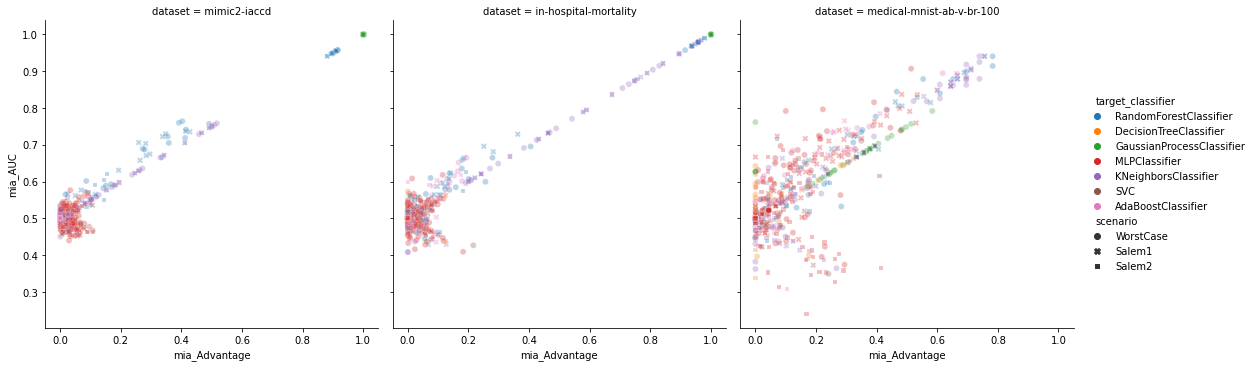

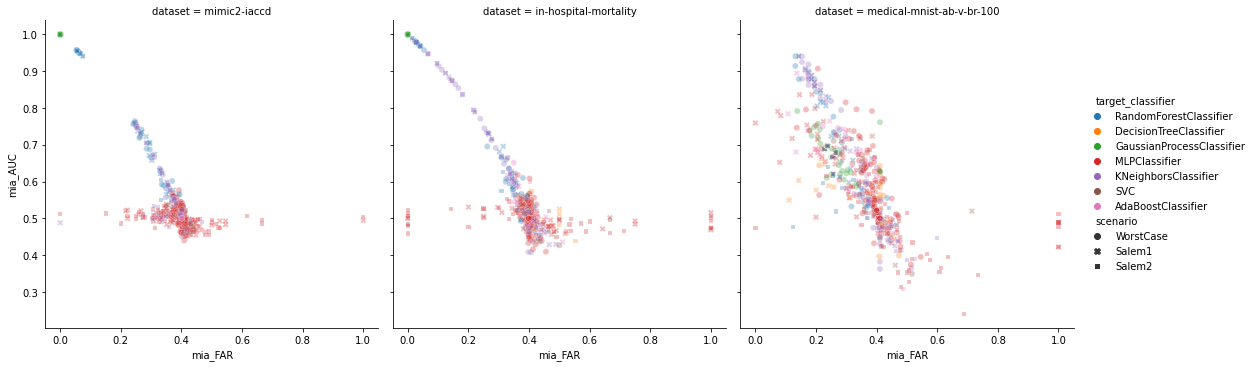

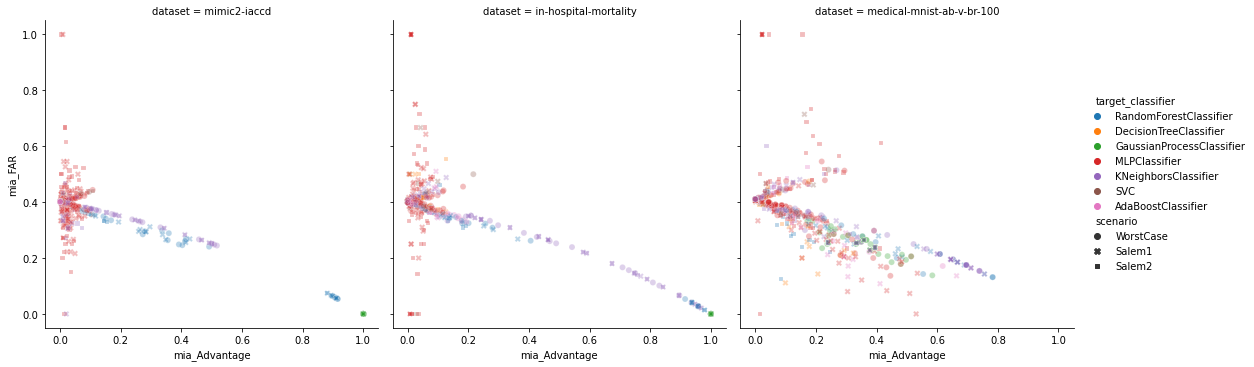

In [13]:
logging.getLogger('matplotlib').setLevel(logging.WARNING)
sns.relplot(
    data=results_df, x="mia_Advantage", y="mia_AUC",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)
sns.relplot(
    data=results_df, x="mia_FAR", y="mia_AUC",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)
sns.relplot(
    data=results_df, x="mia_Advantage", y="mia_FAR",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


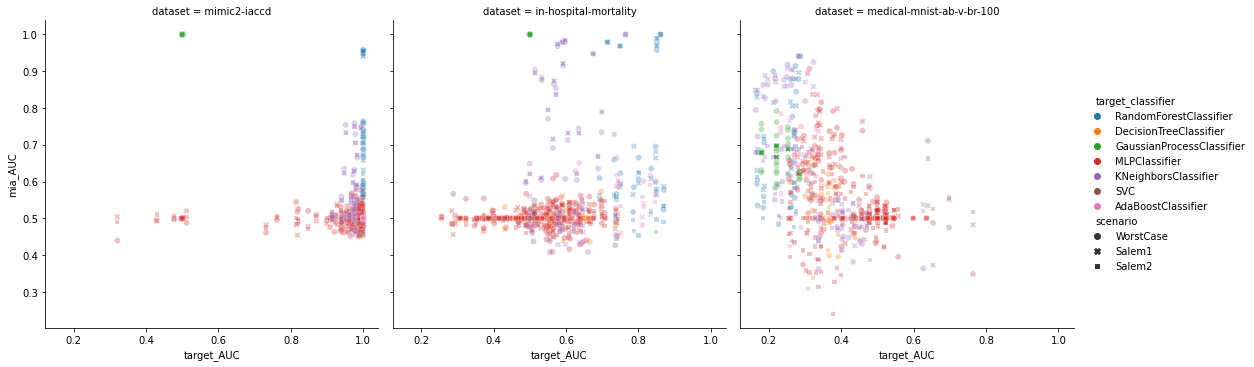

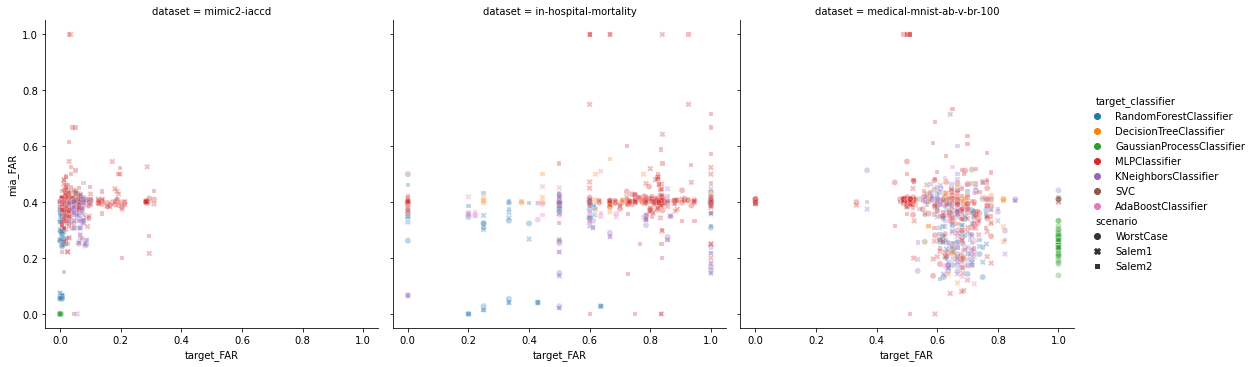

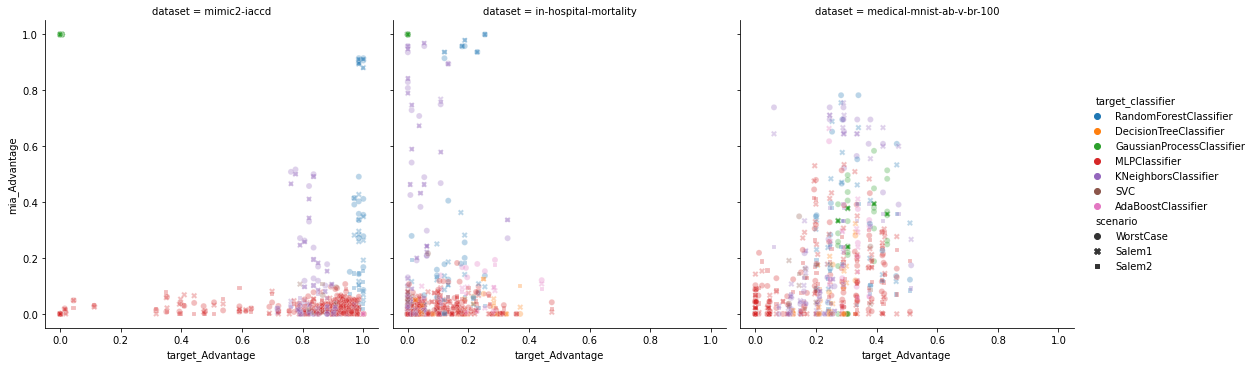

In [14]:
sns.relplot(
    data=results_df, x="target_AUC", y="mia_AUC",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)
sns.relplot(
    data=results_df, x="target_FAR", y="mia_FAR",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)
sns.relplot(
    data=results_df, x="target_Advantage", y="mia_Advantage",
    hue="target_classifier", style="scenario", col="dataset",
    kind="scatter", alpha=0.3
)

In [41]:
for dt in datasets[:3]:
    print(dt)
    for sc in scenarios:
        print(sc)
scenarios

mimic2-iaccd
WorstCase
Salem1
Salem2
in-hospital-mortality
WorstCase
Salem1
Salem2
medical-mnist-ab-v-br-100
WorstCase
Salem1
Salem2


['WorstCase', 'Salem1', 'Salem2']

mimic2-iaccd WorstCase


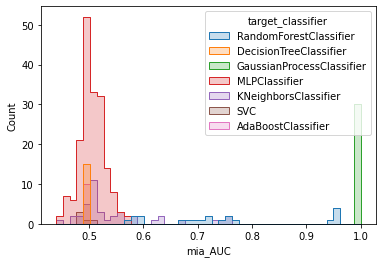

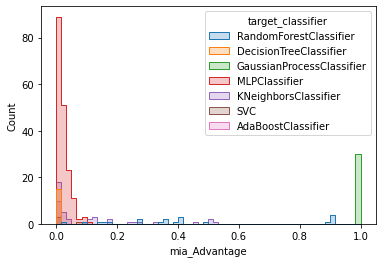

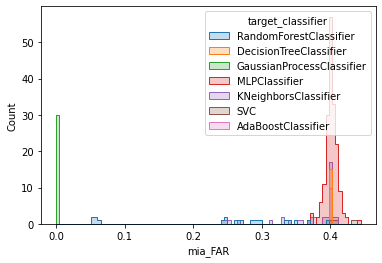

mimic2-iaccd Salem1


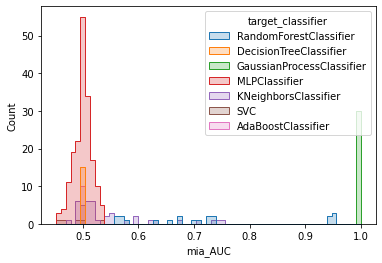

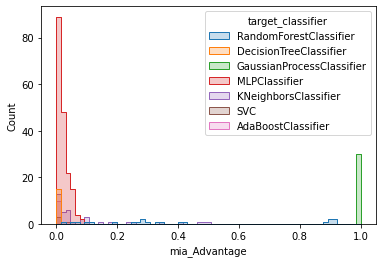

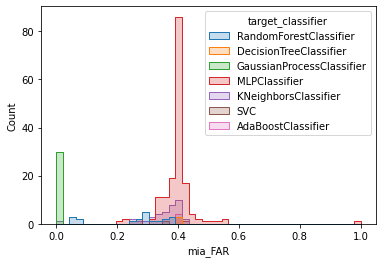

mimic2-iaccd Salem2


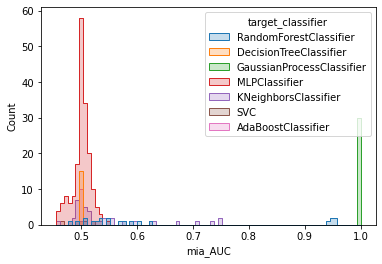

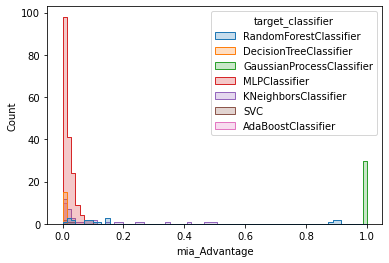

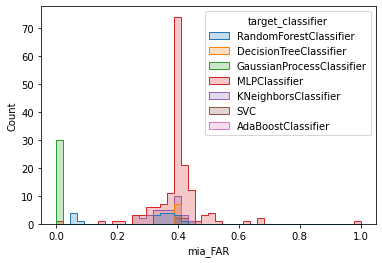

in-hospital-mortality WorstCase


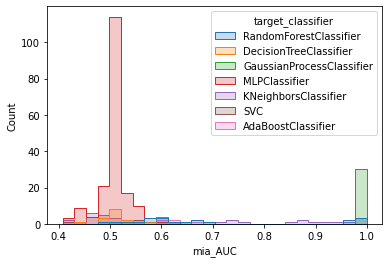

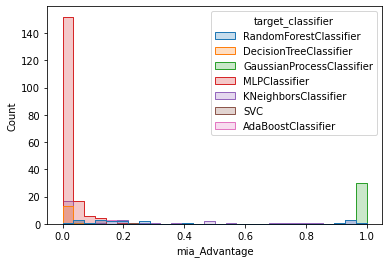

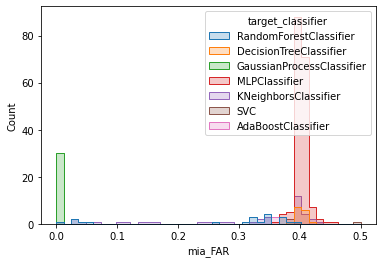

in-hospital-mortality Salem1


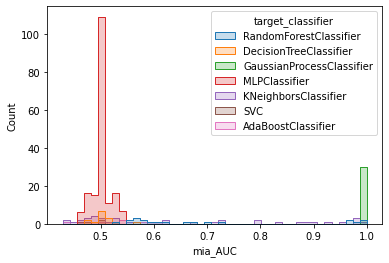

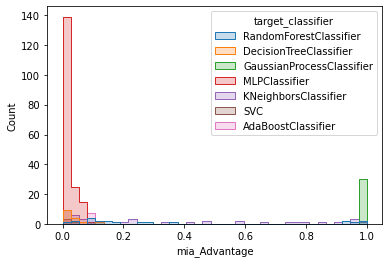

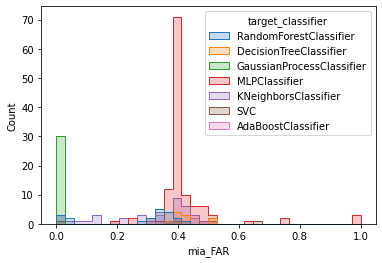

in-hospital-mortality Salem2


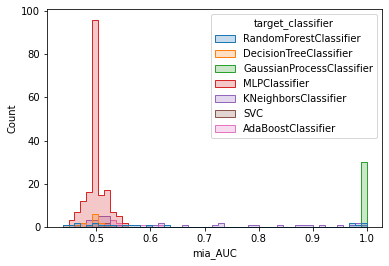

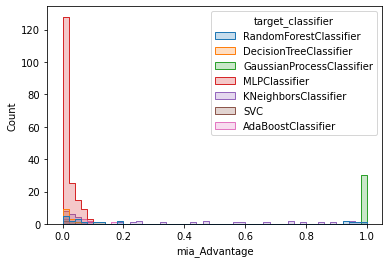

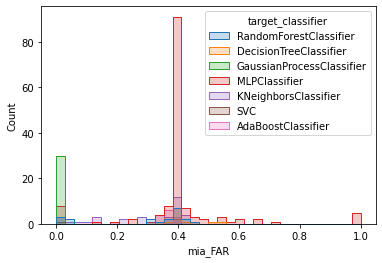

medical-mnist-ab-v-br-100 WorstCase


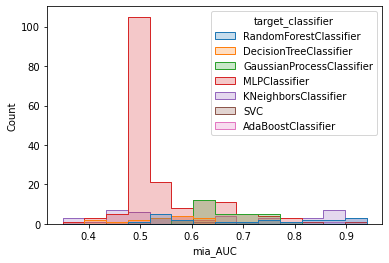

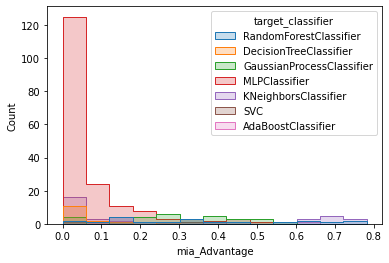

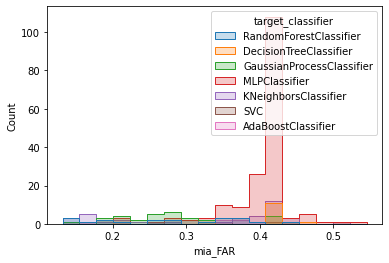

medical-mnist-ab-v-br-100 Salem1


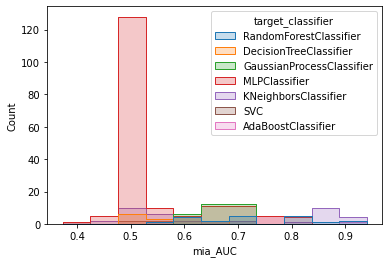

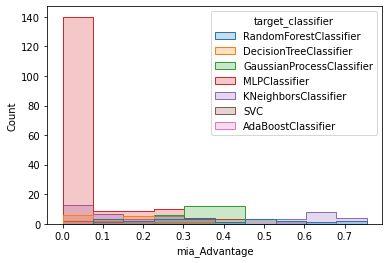

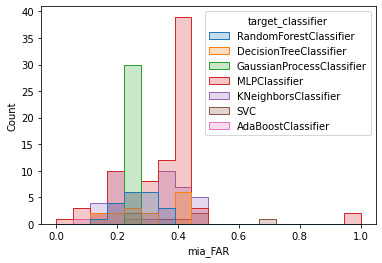

medical-mnist-ab-v-br-100 Salem2


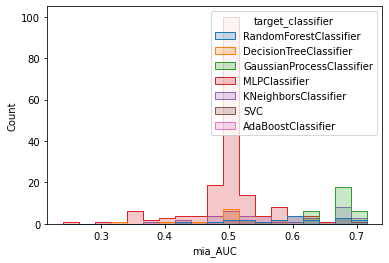

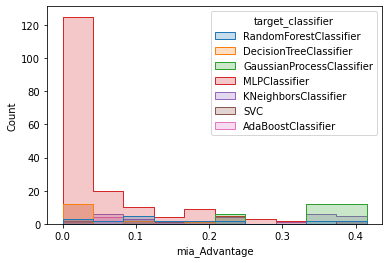

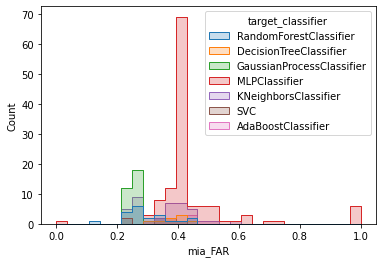

In [42]:
for dt in datasets[:3]:
    for sc in scenarios:
        print(dt, sc)
        g = sns.histplot(results_df[(results_df['dataset']==dt) & (results_df['scenario']==sc)], 
                     x="mia_AUC",hue="target_classifier", element="step")#, title=f'{dt} {sc}')
        plt.show()
        plt.close("all")
        f = sns.histplot(results_df[(results_df['dataset']==dt) & (results_df['scenario']==sc)], 
             x="mia_Advantage",hue="target_classifier", element="step")#, title=f'{dt} {sc}')
        plt.show()
        plt.close("all")
        p = sns.histplot(results_df[(results_df['dataset']==dt) & (results_df['scenario']==sc)], 
             x="mia_FAR",hue="target_classifier", element="step")#, title=f'{dt} {sc}')
        plt.show()
        plt.close("all")